# Cohort Revenue Retention Analysis: A Bayesian Approach

In this notebook we extend the cohort retention model presented in the post [Cohort Retention Analysis with BART](https://juanitorduz.github.io/retention_bart/) so that we just model retention **and**  per cohort simultaneously (we recommend reading the referenced post before this one).  The idea is to keep modeling the retention using a Bayesian Additive Regression Tree (BART) model (see [`pymc-bart`](https://www.pymc.io/projects/bart/en/latest/)) and linearly model the revenue per cohort using a Gamma distribution. We couple the retention and revenue components in a similar way as presented in the notebook [Introduction to Bayesian A/B Testing](https://www.pymc.io/projects/examples/en/latest/case_studies/bayesian_ab_testing_introduction.html). For this simulated example we use a synthetic data set, see the blog post [A Simple Cohort Retention Analysis in PyMC](https://juanitorduz.github.io/retention/) For more details. [Here](https://github.com/juanitorduz/website_projects/blob/master/data/retention_data.csv) you can find the data to reproduce the results.

## Prepare Notebook

In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
import seaborn as sns
from flax import linen as nn
from jax import random
from numpyro.contrib.module import flax_module
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal
from numpyro.infer.util import Predictive
from scipy.special import logit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    MaxAbsScaler,
    OneHotEncoder,
    StandardScaler,
)

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = sum(map(ord, "retention"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Read Data

We start by reading the data from previous posts (see [here](https://github.com/juanitorduz/website_projects/blob/master/Python/retantion_data.py) for the code to generate the data).

In [3]:
data_df = pd.read_csv(
    "https://raw.githubusercontent.com/juanitorduz/website_projects/master/data/retention_data.csv",
    parse_dates=["cohort", "period"],
)

data_df.head()

,cohort,n_users,period,age,cohort_age,retention_true_mu,retention_true,n_active_users,revenue,retention
0,2020-01-01,150,2020-01-01,1430,0,-1.807373,0.140956,150,14019.256906,1.000000
1,2020-01-01,150,2020-02-01,1430,31,-1.474736,0.186224,25,1886.501237,0.166667
2,2020-01-01,150,2020-03-01,1430,60,-2.281286,0.092685,13,1098.136314,0.086667
3,2020-01-01,150,2020-04-01,1430,91,-3.206610,0.038918,6,477.852458,0.040000
4,2020-01-01,150,2020-05-01,1430,121,-3.112983,0.042575,2,214.667937,0.013333


## Data Preprocessing

In order to understand the user vs revenue relation, let's compute the revenue per users and per *active* users. The former represent the overall cohort contribution and the latter the contribution of the active users.

In [4]:
data_df["revenue_per_users"] = data_df["revenue"] / data_df["n_users"]
data_df["revenue_per_active_users"] = data_df["revenue"] / data_df["n_active_users"]

Observe that we have certain `periods` where we do not have active users. This induces `NaN` values in the `revenue_per_active_users`.

In [5]:
data_df.query("revenue_per_active_users.isna()")

,cohort,n_users,period,age,cohort_age,retention_true_mu,retention_true,n_active_users,revenue,retention,revenue_per_users,revenue_per_active_users
53,2020-02-01,62,2020-07-01,1399,151,-3.542850,0.028117,0,0.0,0.0,0.0,NaN
55,2020-02-01,62,2020-09-01,1399,213,-3.111235,0.042646,0,0.0,0.0,0.0,NaN
78,2020-02-01,62,2022-08-01,1399,912,-4.465784,0.011365,0,0.0,0.0,0.0,NaN
87,2020-02-01,62,2023-05-01,1399,1185,-3.877776,0.020277,0,0.0,0.0,0.0,NaN
90,2020-02-01,62,2023-08-01,1399,1277,-4.726498,0.008780,0,0.0,0.0,0.0,NaN


We fill these missing values with zero.

In [6]:
data_df = data_df.fillna(value={"revenue_per_active_users": 0.0})

We make a data train-test split.

In [7]:
period_train_test_split = "2022-11-01"

train_data_df = data_df.query("period <= @period_train_test_split")
test_data_df = data_df.query("period > @period_train_test_split")
test_data_df = test_data_df[
    test_data_df["cohort"].isin(train_data_df["cohort"].unique())
]

## EDA

For a detailed EDA of the data, please refer to the previous posts ([A Simple Cohort Retention Analysis in PyMC](https://juanitorduz.github.io/retention/) and [Cohort Retention Analysis with BART](https://juanitorduz.github.io/retention_bart/)). Here we want to focus in the retention and revenue relation.  First, let's recall how the retention matrix looks like.

Text(0.5, 1.0, 'Retention by Cohort and Period')

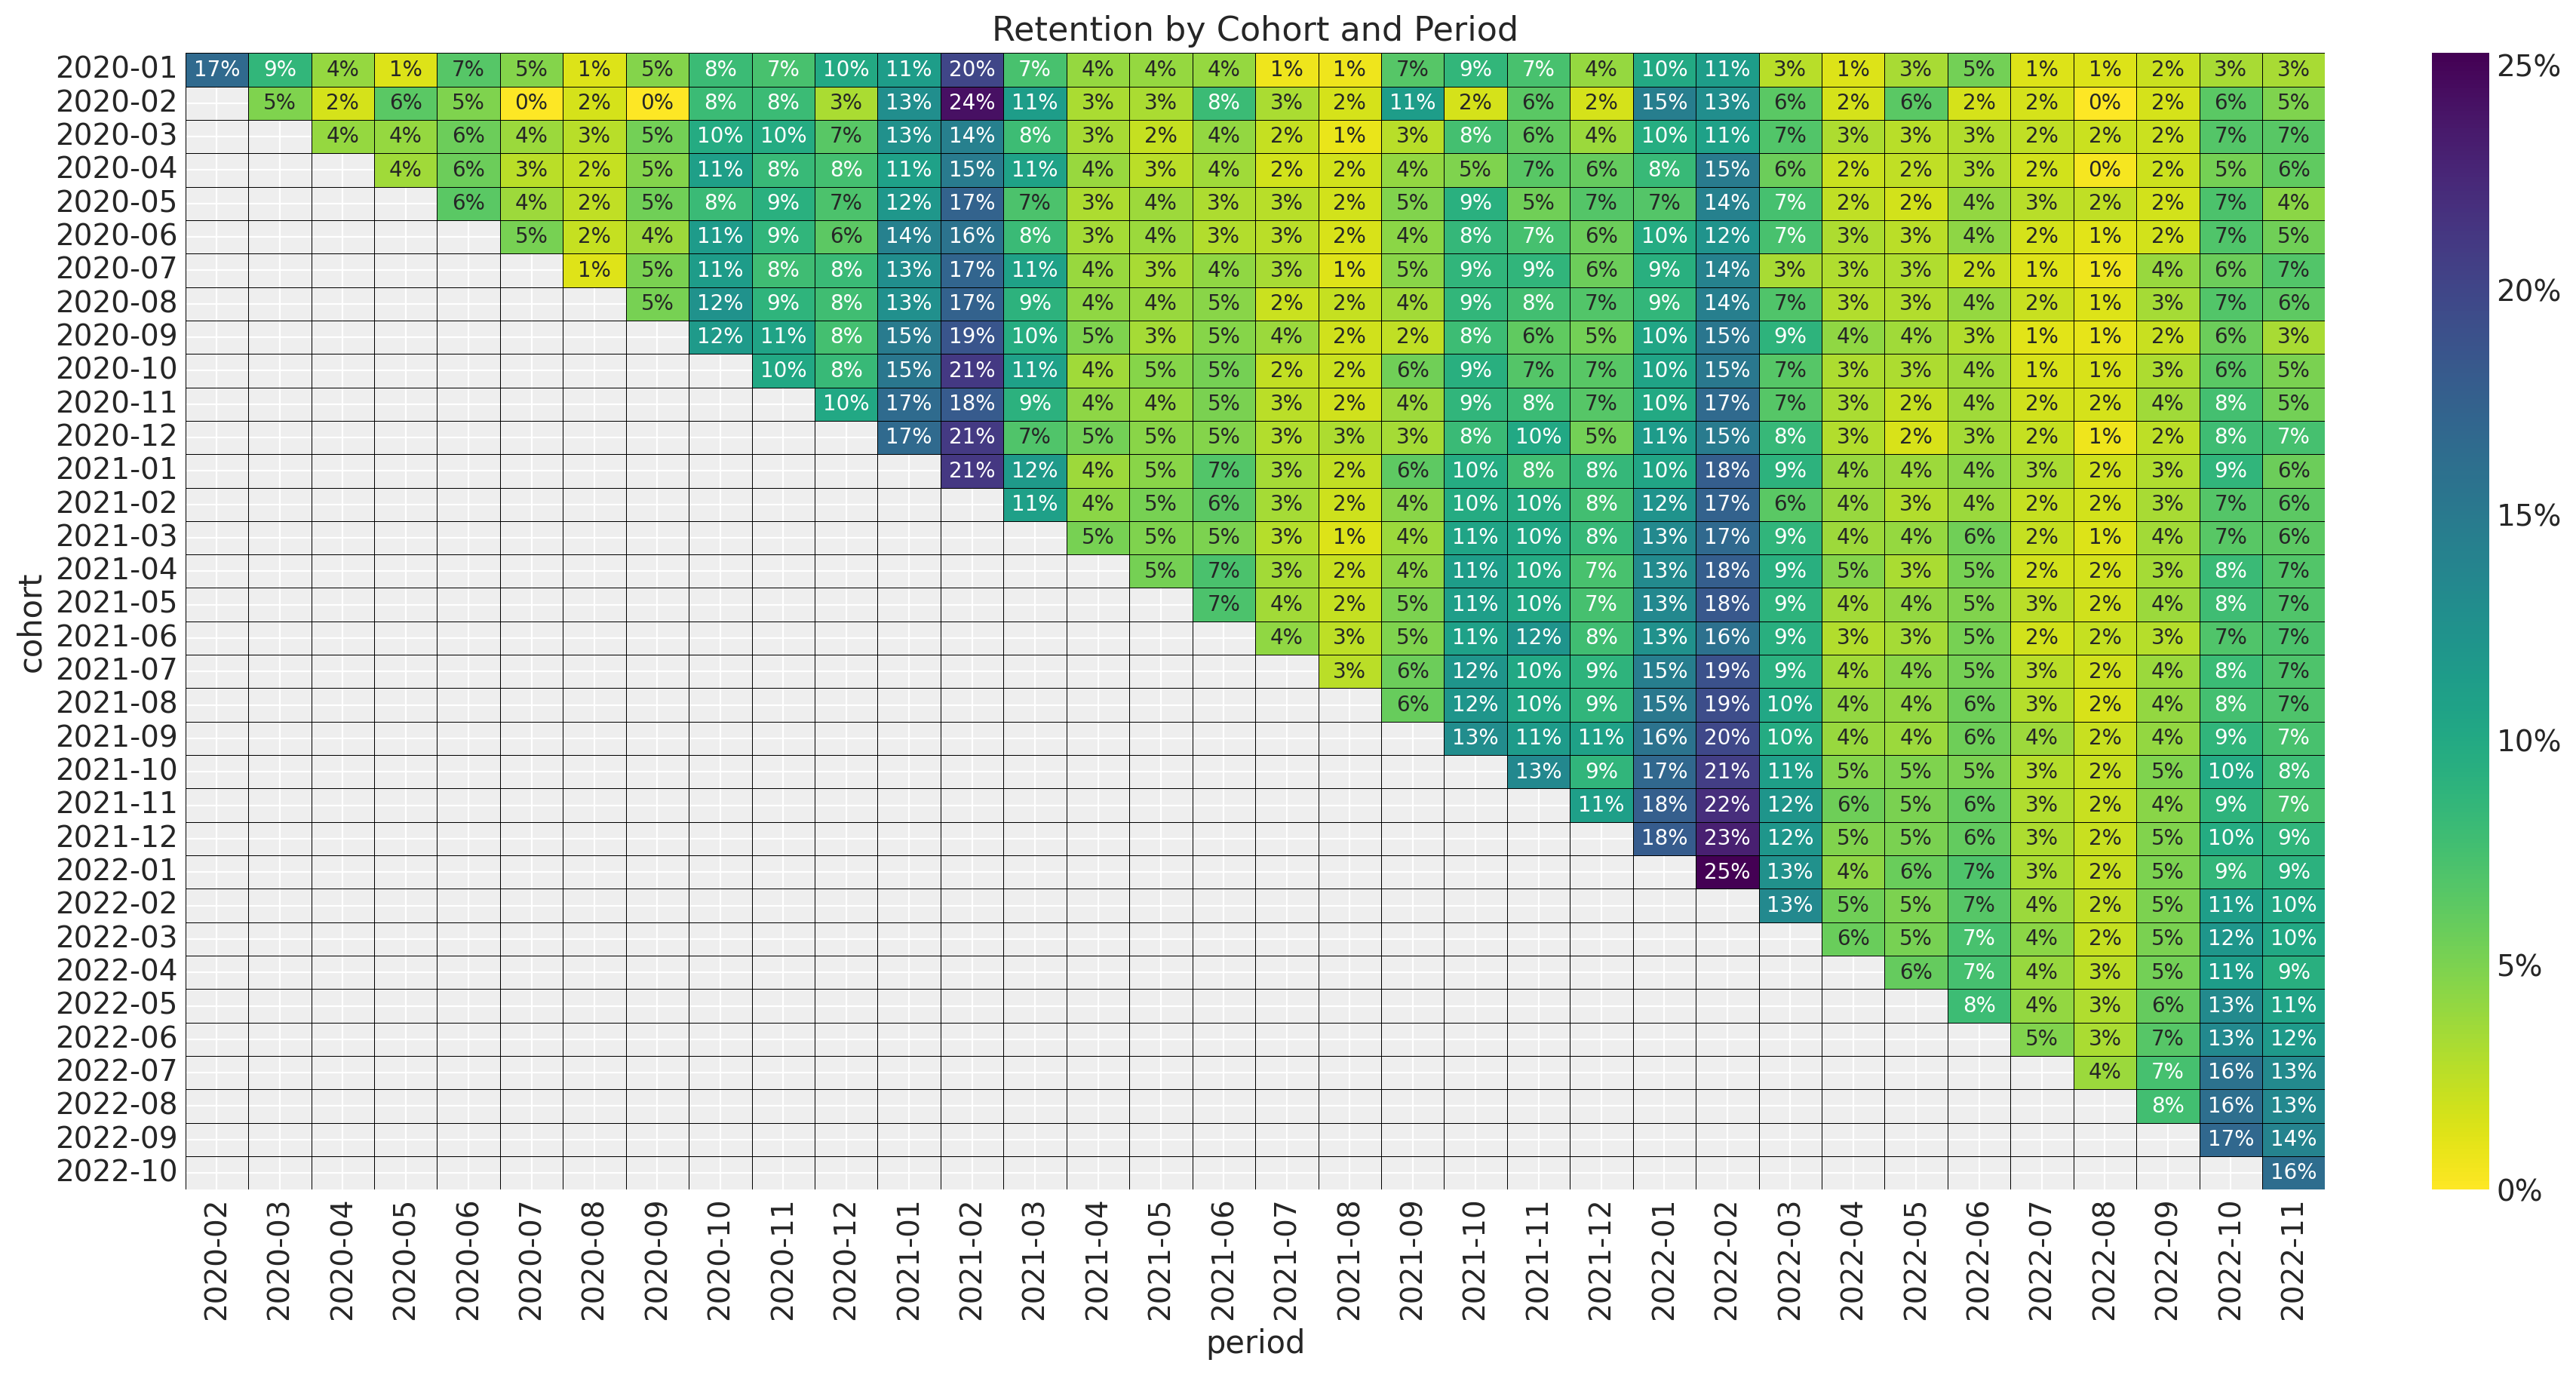

In [8]:
fig, ax = plt.subplots(figsize=(17, 9))

(
    train_data_df.assign(
        cohort=lambda df: df["cohort"].dt.strftime("%Y-%m"),
        period=lambda df: df["period"].dt.strftime("%Y-%m"),
    )
    .query("cohort_age != 0")
    .filter(["cohort", "period", "retention"])
    .pivot_table(index="cohort", columns="period", values="retention")
    .pipe(
        (sns.heatmap, "data"),
        cmap="viridis_r",
        linewidths=0.2,
        linecolor="black",
        annot=True,
        fmt="0.0%",
        cbar_kws={"format": mtick.FuncFormatter(func=lambda y, _: f"{y :0.0%}")},
        ax=ax,
    )
)

ax.set_title("Retention by Cohort and Period")

## Model

Motivated by the analysis above we suggest the following retention-revenue model.

\begin{align*}
\text{Revenue} & \sim \text{Gamma}(N_{\text{active}}, \lambda) \\
\log(\lambda) = (& \text{intercept} \\
    & + \beta_{\text{cohort age}} \text{cohort age} \\
    & + \beta_{\text{age}} \text{age} \\
    & + \beta_{\text{cohort age} \times \text{age}} \text{cohort age} \times \text{age} ) \\
N_{\text{active}} & \sim \text{Binomial}(N_{\text{total}}, p) \\
\textrm{logit}(p) & = \text{BART}(\text{cohort age}, \text{age}, \text{month})
\end{align*}

### Data Transformations

We do similar transformations as in the previous posts.

In [9]:
eps = np.finfo(float).eps
train_data_red_df = train_data_df.query("cohort_age > 0").reset_index(drop=True)
train_obs_idx = train_data_red_df.index.to_numpy()
train_n_users = train_data_red_df["n_users"].to_numpy()
train_n_active_users = train_data_red_df["n_active_users"].to_numpy()
train_retention = train_data_red_df["retention"].to_numpy()
train_retention_logit = logit(train_retention + eps)
train_data_red_df["month"] = train_data_red_df["period"].dt.strftime("%m").astype(int)
train_data_red_df["cohort_month"] = (
    train_data_red_df["cohort"].dt.strftime("%m").astype(int)
)
train_data_red_df["period_month"] = (
    train_data_red_df["period"].dt.strftime("%m").astype(int)
)
train_revenue = train_data_red_df["revenue"].to_numpy() + eps
train_revenue_per_user = train_revenue / (train_n_active_users + eps)

train_cohort = train_data_red_df["cohort"].to_numpy()
train_cohort_encoder = LabelEncoder()
train_cohort_idx = train_cohort_encoder.fit_transform(train_cohort).flatten()
train_period = train_data_red_df["period"].to_numpy()
train_period_encoder = LabelEncoder()
train_period_idx = train_period_encoder.fit_transform(train_period).flatten()

features: list[str] = ["age", "cohort_age", "month"]
x_train = train_data_red_df[features]

train_age = train_data_red_df["age"].to_numpy()
train_age_scaler = MaxAbsScaler()
train_age_scaled = train_age_scaler.fit_transform(train_age.reshape(-1, 1)).flatten()
train_cohort_age = train_data_red_df["cohort_age"].to_numpy()
train_cohort_age_scaler = MaxAbsScaler()
train_cohort_age_scaled = train_cohort_age_scaler.fit_transform(
    train_cohort_age.reshape(-1, 1)
).flatten()

In [10]:
train_n_users = jnp.array(train_n_users)
train_n_active_users = jnp.array(train_n_active_users)
train_revenue = jnp.array(train_revenue)

In [11]:
numerical_features = ["age", "cohort_age"]
categorical_features = ["month"]

numerical_transformer = Pipeline(steps=[("scaler", StandardScaler())])
categorical_features_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder(sparse_output=False))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_features_transformer, categorical_features),
    ]
).set_output(transform="pandas")

preprocessor.fit(x_train)
x_train_preprocessed = preprocessor.transform(x_train)

x_train_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595 entries, 0 to 594
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   num__age         595 non-null    float64
 1   num__cohort_age  595 non-null    float64
 2   cat__month_1     595 non-null    float64
 3   cat__month_2     595 non-null    float64
 4   cat__month_3     595 non-null    float64
 5   cat__month_4     595 non-null    float64
 6   cat__month_5     595 non-null    float64
 7   cat__month_6     595 non-null    float64
 8   cat__month_7     595 non-null    float64
 9   cat__month_8     595 non-null    float64
 10  cat__month_9     595 non-null    float64
 11  cat__month_10    595 non-null    float64
 12  cat__month_11    595 non-null    float64
 13  cat__month_12    595 non-null    float64
dtypes: float64(14)
memory usage: 65.2 KB


In [12]:
x_train_preprocessed_array = jnp.array(x_train_preprocessed)

In [13]:
class RetentionMLP(nn.Module):
    layers: list[int]

    @nn.compact
    def __call__(self, x):
        for num_features in self.layers:
            x = nn.sigmoid(nn.Dense(features=num_features)(x))
        return x

In [14]:
def model(x, n_users, n_active_users=None):
    retention_nn = flax_module(
        "retention_nn", RetentionMLP(layers=[16, 8, 1]), input_shape=(x.shape[1],)
    )
    retention = numpyro.deterministic("retention", retention_nn(x).squeeze(-1))

    with numpyro.plate("data", len(x)):
        numpyro.sample(
            "likelihood",
            dist.Binomial(total_count=n_users, probs=retention),
            obs=n_active_users,
        )

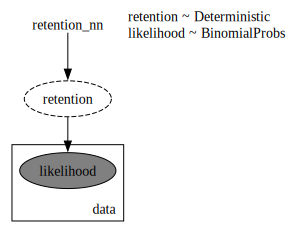

In [15]:
numpyro.render_model(
    model=model,
    model_kwargs={
        "x": x_train_preprocessed_array,
        "n_users": train_n_users,
        "n_active_users": train_n_active_users,
    },
    render_distributions=True,
    render_params=True,
)

100%|██████████| 700/700 [00:00<00:00, 997.21it/s, init loss: 747648.4375, avg. loss [666-700]: 2395.3870] 


Text(0.5, 1.0, 'ELBO loss')

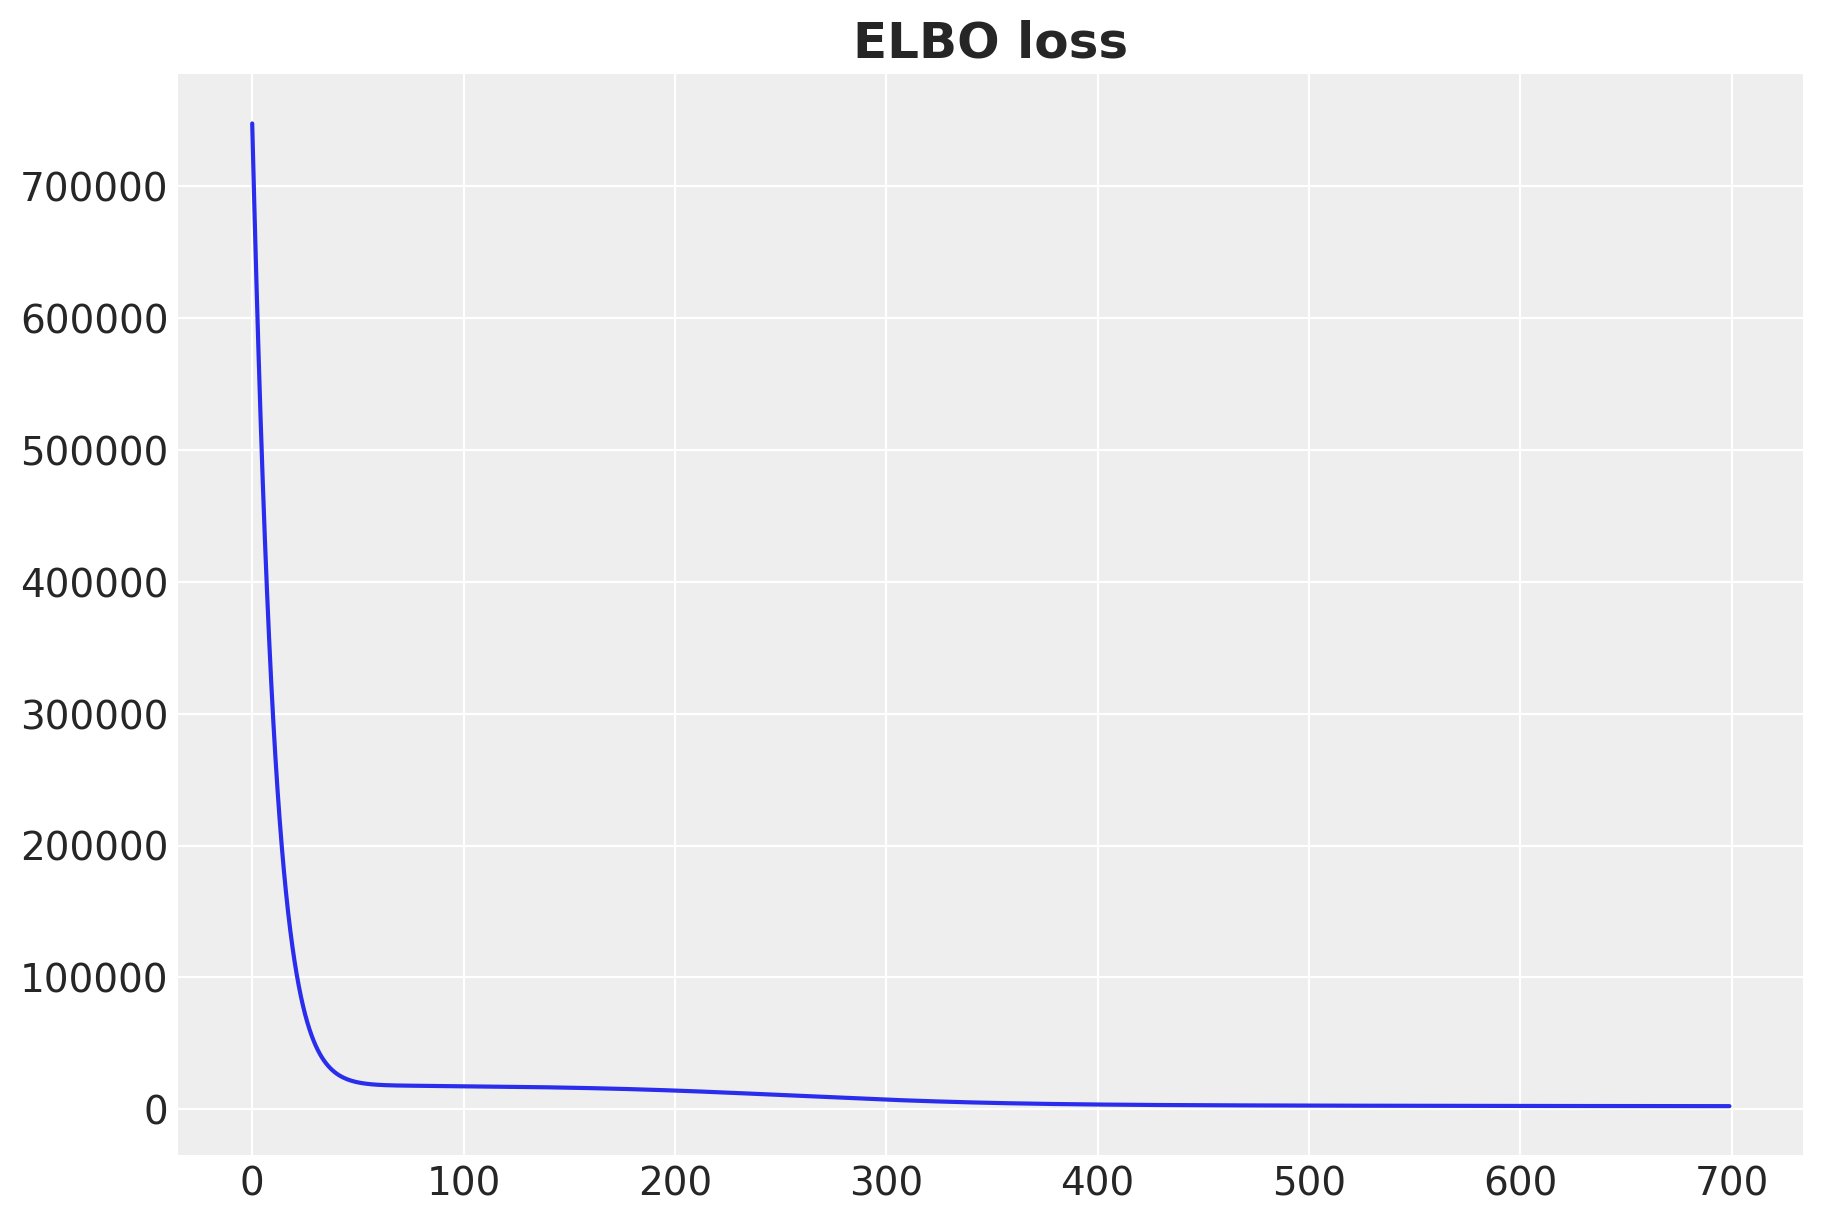

In [16]:
guide = AutoNormal(model=model)
optimizer = numpyro.optim.Adam(step_size=0.01)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
n_samples = 700
rng_key, rng_subkey = random.split(key=rng_key)
svi_result = svi.run(
    rng_subkey,
    n_samples,
    x_train_preprocessed_array,
    train_n_users,
    train_n_active_users,
)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(svi_result.losses)
ax.set_title("ELBO loss", fontsize=18, fontweight="bold")

In [17]:
params = svi_result.params

posterior_predictive = Predictive(
    model=model, guide=guide, params=params, num_samples=4 * 2_000
)
rng_key, rng_subkey = random.split(key=rng_key)
posterior_predictive_samples = posterior_predictive(
    rng_subkey, x_train_preprocessed_array, train_n_users
)

In [18]:
idata_svi = az.from_dict(
    posterior_predictive={
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in posterior_predictive_samples.items()
    },
    coords={"obs_idx": train_obs_idx},
    dims={"retention": ["obs_idx"], "likelihood": ["obs_idx"]},
)

Text(0.5, 1.0, 'True vs Predicted Retention (Train)')

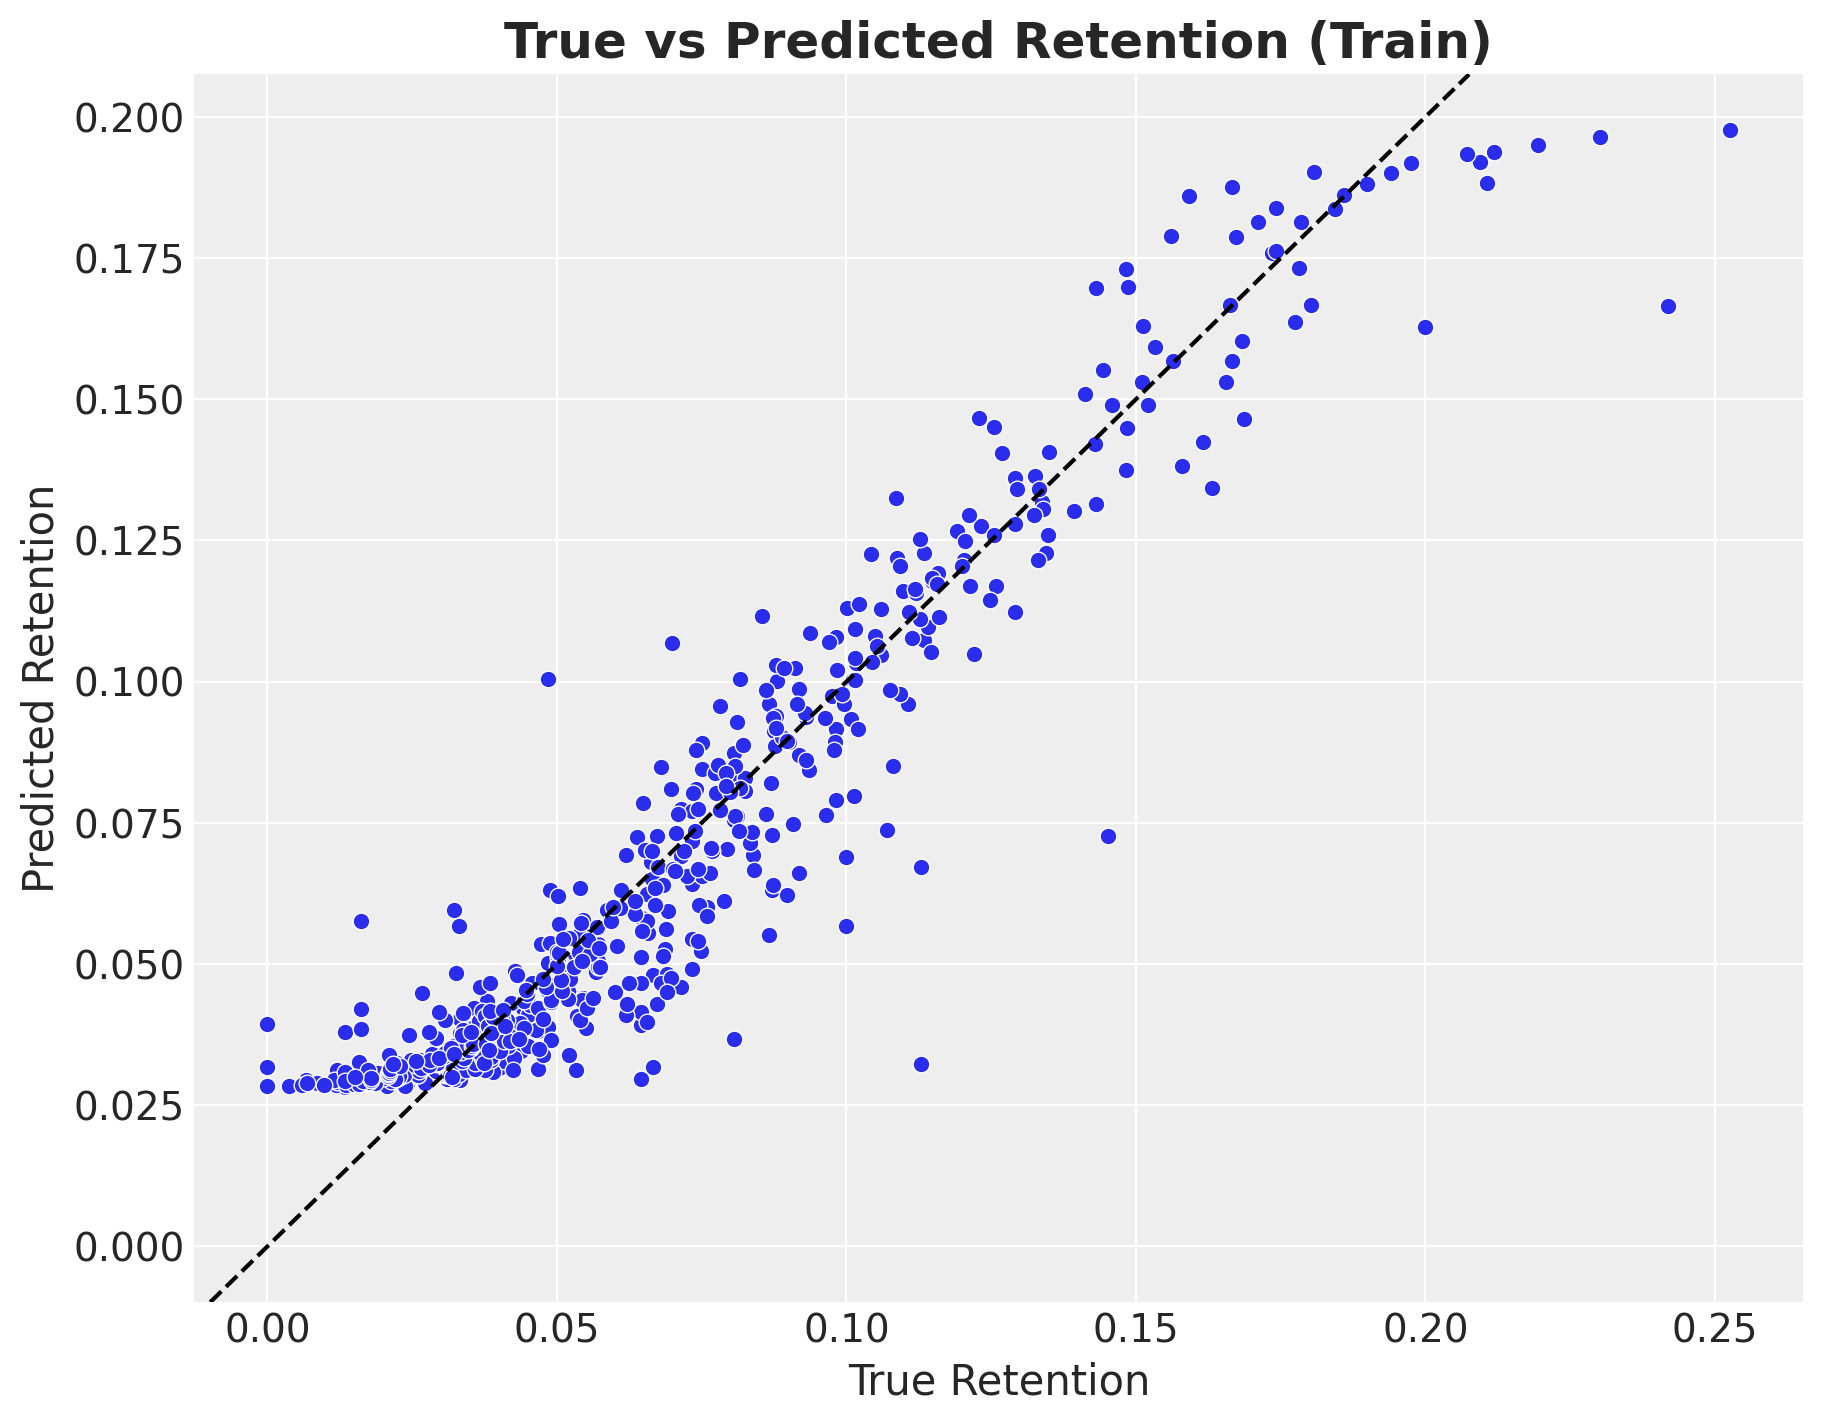

In [19]:
fig, ax = plt.subplots(figsize=(9, 7))
sns.scatterplot(
    x=train_retention,
    y=idata_svi["posterior_predictive"]["retention"].mean(dim=["chain", "draw"]),
    color="C0",
    ax=ax,
)
ax.axline((0, 0), slope=1, color="black", linestyle="--", label="diagonal")
ax.set(xlabel="True Retention", ylabel="Predicted Retention")
ax.set_title(
    label="True vs Predicted Retention (Train)", fontsize=18, fontweight="bold"
)

/var/folders/4r/dzmwyydj3mbggyfwbs1cklvh0000gn/T/ipykernel_36061/2651304601.py:45: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.autofmt_xdate()


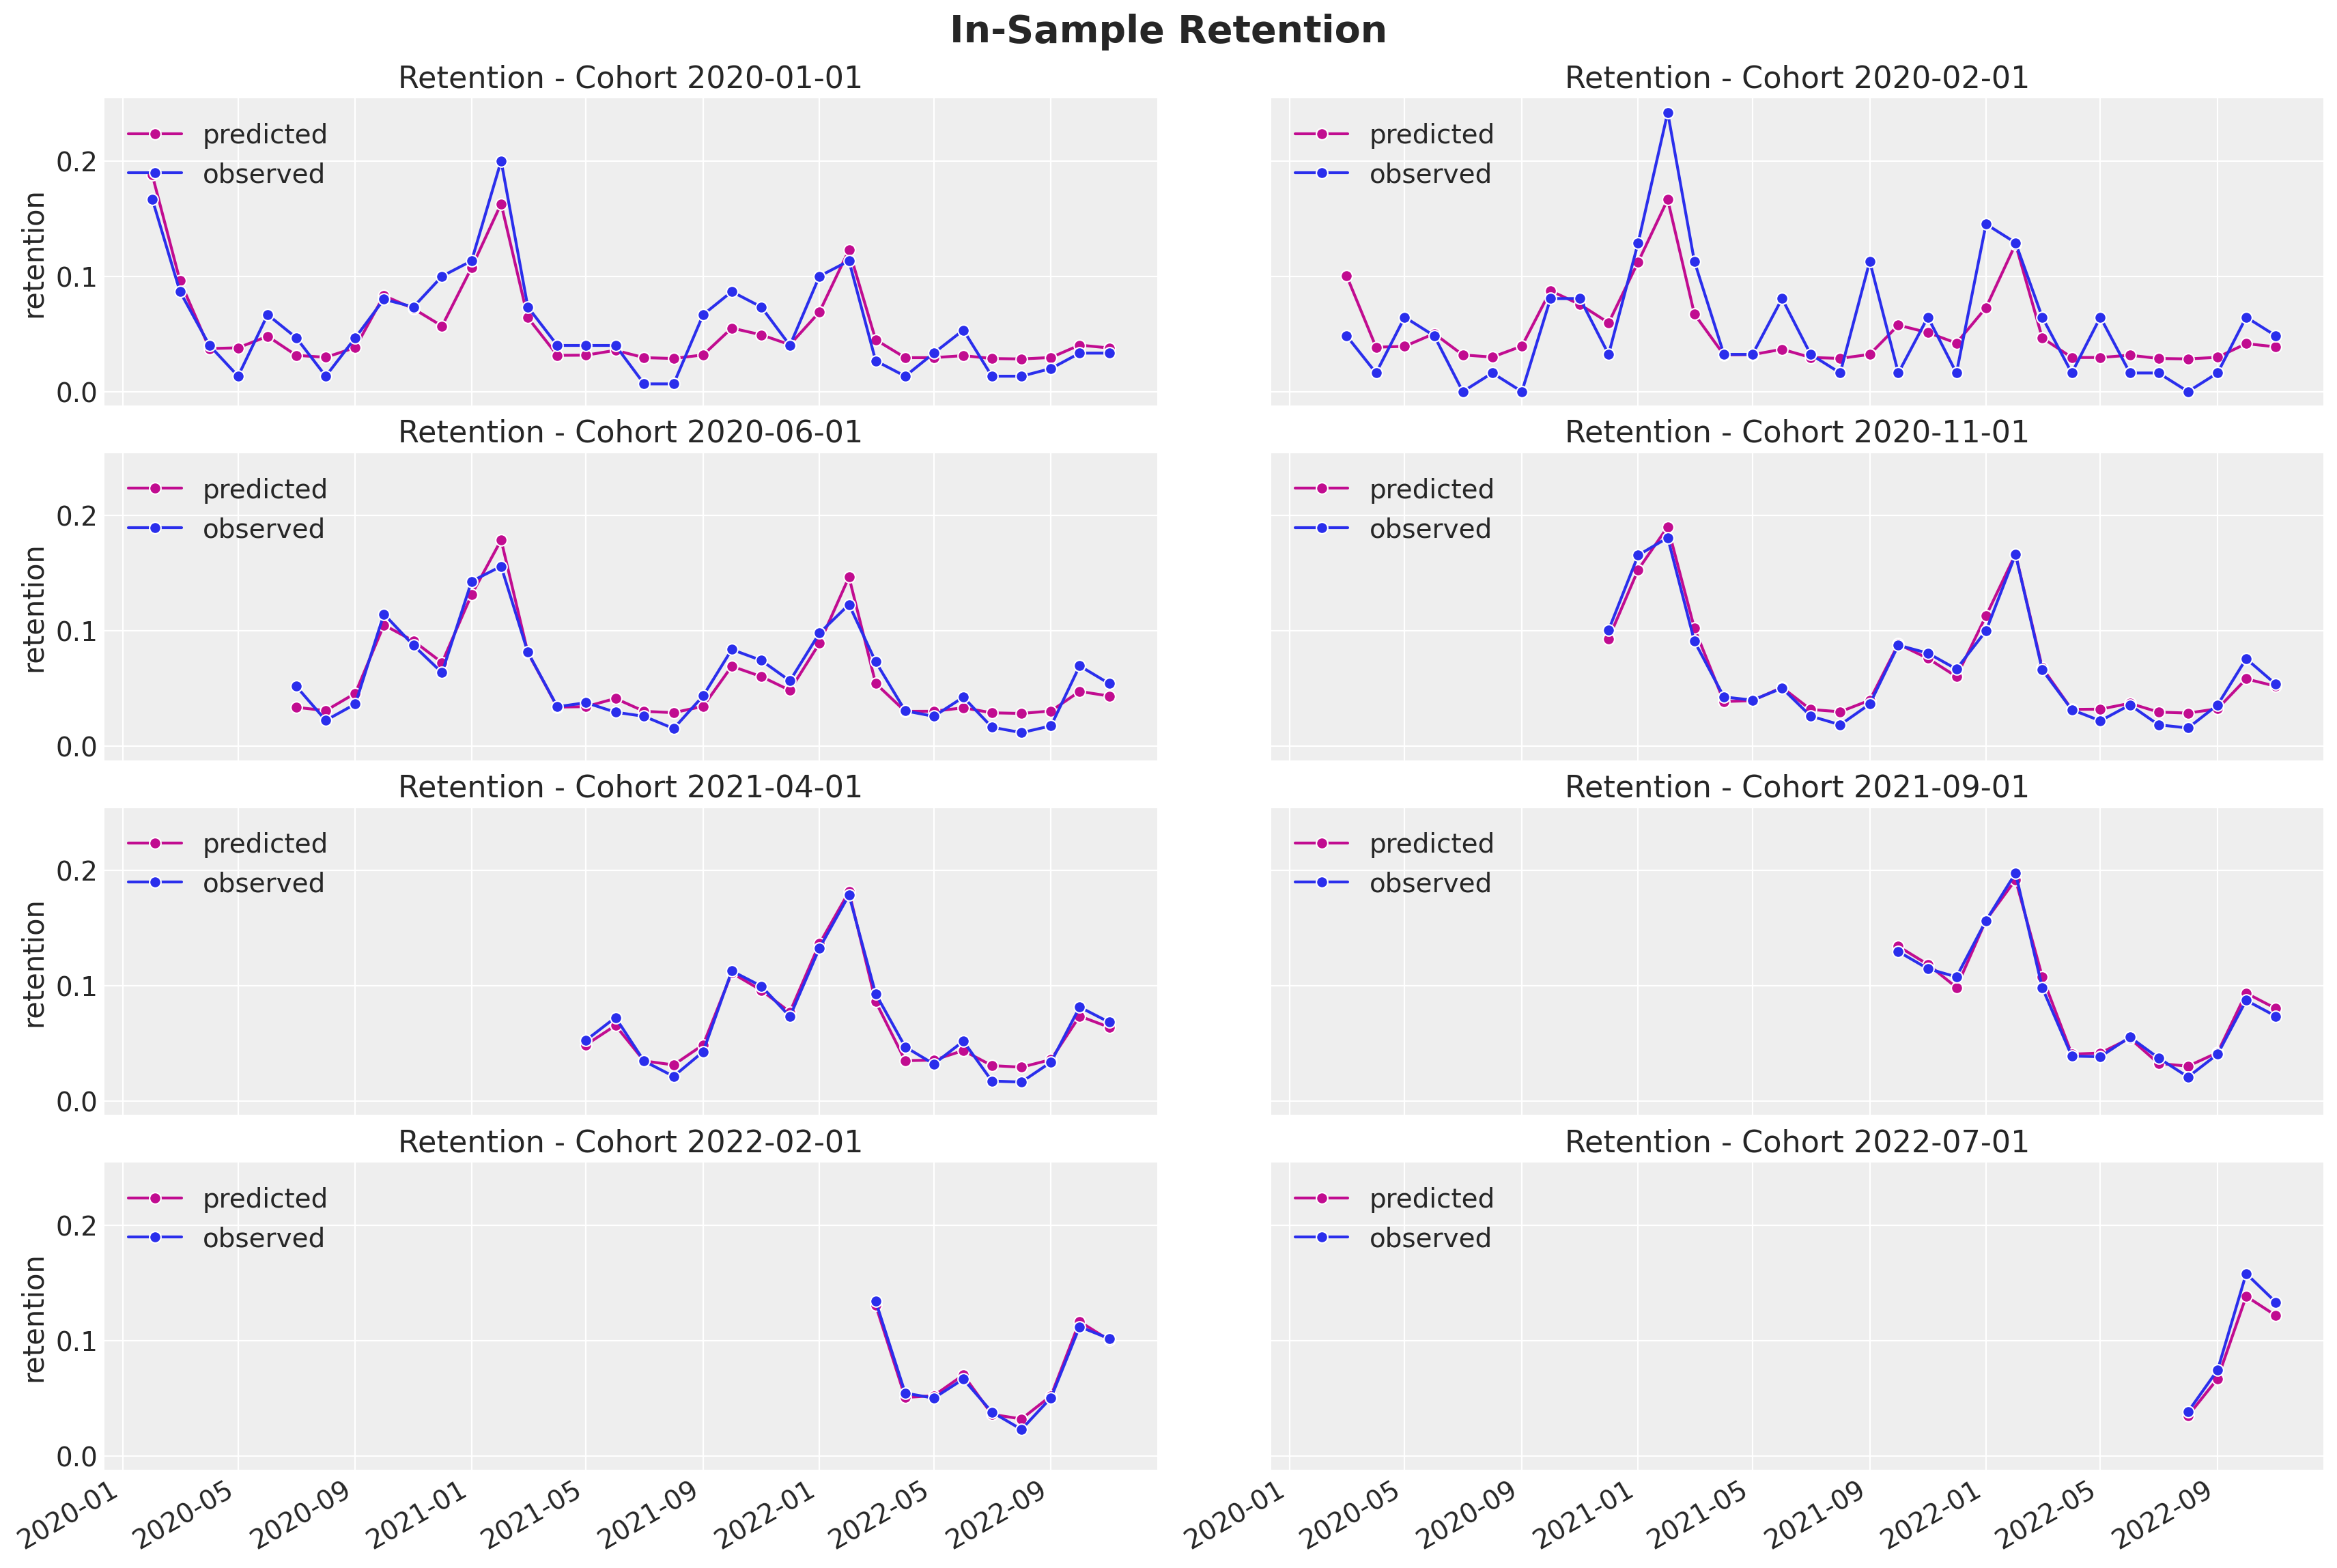

In [28]:
def plot_train_retention_cohort(cohort_index: int, ax: plt.Axes) -> plt.Axes:
    mask = train_cohort_idx == cohort_index

    sns.lineplot(
        x=train_period[train_period_idx[mask]],
        y=idata_svi["posterior_predictive"]["retention"].mean(dim=["chain", "draw"])[
            mask
        ],
        marker="o",
        color="C3",
        label="predicted",
        ax=ax,
    )
    sns.lineplot(
        x=train_period[train_period_idx[mask]],
        y=train_retention[mask],
        color="C0",
        marker="o",
        label="observed",
        ax=ax,
    )
    cohort_name = (
        pd.to_datetime(train_cohort_encoder.classes_[cohort_index]).date().isoformat()
    )
    ax.legend(loc="upper left")
    ax.set(title=f"Retention - Cohort {cohort_name}")
    return ax


cohort_index_to_plot = [0, 1, 5, 10, 15, 20, 25, 30]

fig, axes = plt.subplots(
    nrows=np.ceil(len(cohort_index_to_plot) / 2).astype(int),
    ncols=2,
    figsize=(17, 11),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for cohort_index, ax in zip(cohort_index_to_plot, axes.flatten(), strict=True):
    plot_train_retention_cohort(cohort_index=cohort_index, ax=ax)

fig.suptitle("In-Sample Retention", y=1.03, fontsize=20, fontweight="bold")
fig.autofmt_xdate()

In [21]:
test_data_red_df = test_data_df.query("cohort_age > 0")
test_data_red_df = test_data_red_df[
    test_data_red_df["cohort"].isin(train_data_red_df["cohort"].unique())
].reset_index(drop=True)
test_obs_idx = test_data_red_df.index.to_numpy()
test_n_users = test_data_red_df["n_users"].to_numpy()
test_n_active_users = test_data_red_df["n_active_users"].to_numpy()
test_retention = test_data_red_df["retention"].to_numpy()
test_revenue = test_data_red_df["revenue"].to_numpy()

test_cohort = test_data_red_df["cohort"].to_numpy()
test_cohort_idx = train_cohort_encoder.transform(test_cohort).flatten()

test_data_red_df["month"] = test_data_red_df["period"].dt.strftime("%m").astype(int)
test_data_red_df["cohort_month"] = (
    test_data_red_df["cohort"].dt.strftime("%m").astype(int)
)
test_data_red_df["period_month"] = (
    test_data_red_df["period"].dt.strftime("%m").astype(int)
)
x_test = test_data_red_df[features]

test_age = test_data_red_df["age"].to_numpy()
test_age_scaled = train_age_scaler.transform(test_age.reshape(-1, 1)).flatten()
test_cohort_age = test_data_red_df["cohort_age"].to_numpy()
test_cohort_age_scaled = train_cohort_age_scaler.transform(
    test_cohort_age.reshape(-1, 1)
).flatten()

In [22]:
test_n_users = jnp.array(test_n_users)
test_n_active_users = jnp.array(test_n_active_users)
test_revenue = jnp.array(test_revenue)

x_test_preprocessed = preprocessor.transform(x_test)
x_test_preprocessed_array = jnp.array(x_test_preprocessed)

In [23]:
test_predictive = Predictive(
    model=model, guide=guide, params=params, num_samples=4 * 2_000
)
rng_key, rng_subkey = random.split(key=rng_key)
test_posterior_predictive_samples = test_predictive(
    rng_subkey, x_test_preprocessed_array, test_n_users
)

In [24]:
test_idata_svi = az.from_dict(
    posterior_predictive={
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in test_posterior_predictive_samples.items()
    },
    coords={"obs_idx": test_obs_idx},
    dims={"retention": ["obs_idx"], "likelihood": ["obs_idx"]},
)

Text(0.5, 1.0, 'True vs Predicted Retention (Test)')

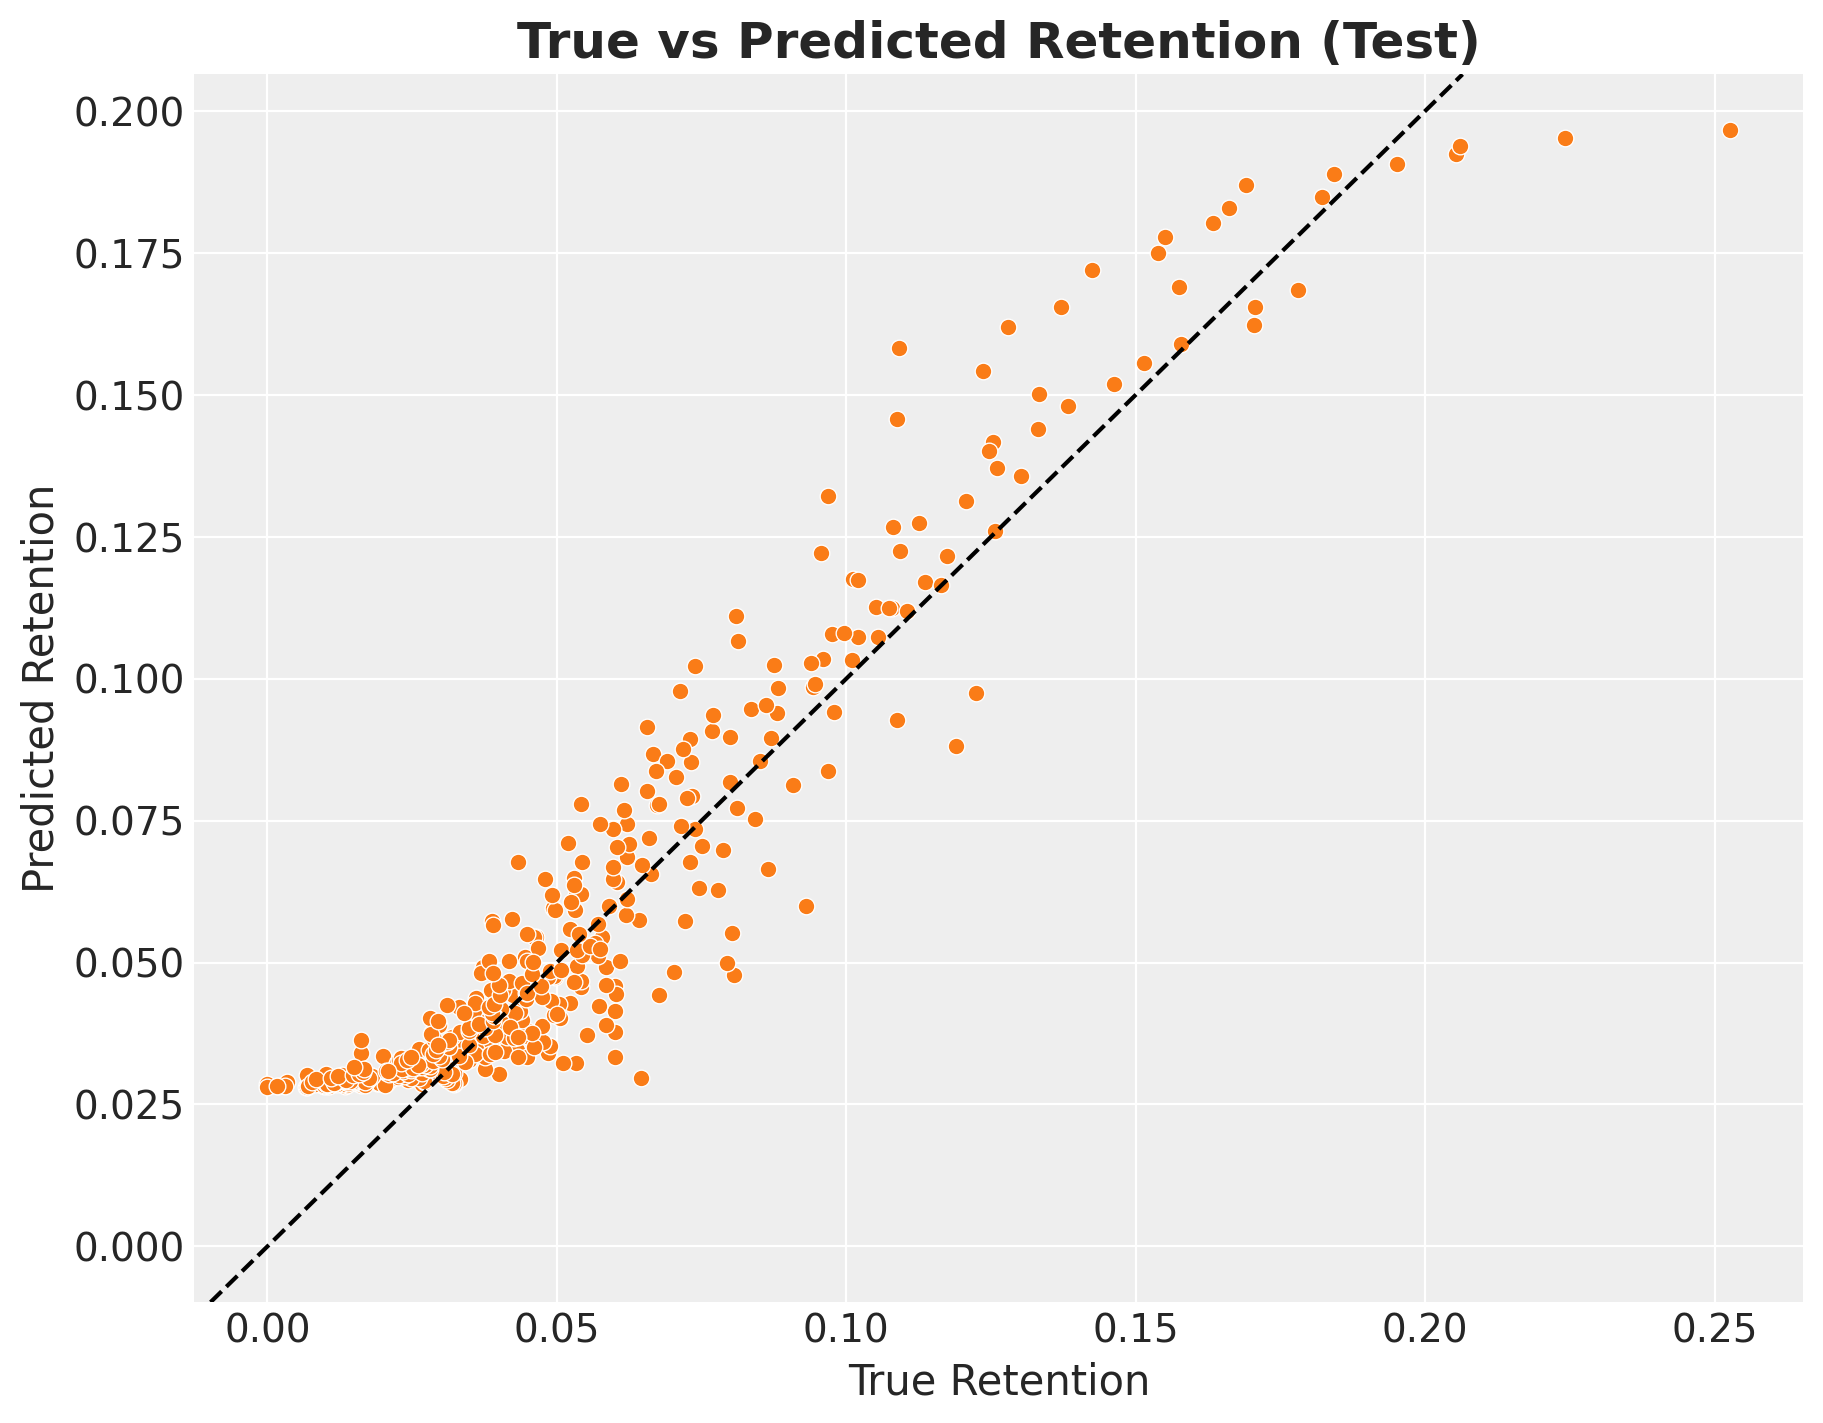

In [25]:
fig, ax = plt.subplots(figsize=(9, 7))
sns.scatterplot(
    x=test_retention,
    y=test_idata_svi["posterior_predictive"]["retention"].mean(dim=["chain", "draw"]),
    color="C1",
    ax=ax,
)
ax.axline((0, 0), slope=1, color="black", linestyle="--", label="diagonal")
ax.set(xlabel="True Retention", ylabel="Predicted Retention")
ax.set_title(label="True vs Predicted Retention (Test)", fontsize=18, fontweight="bold")

In [26]:
def plot_test_retention_cohort(cohort_index: int, ax: plt.Axes) -> plt.Axes:
    mask = test_cohort_idx == cohort_index

    test_period_range = test_data_red_df.query(
        f"cohort == '{train_cohort_encoder.classes_[cohort_index]}'"
    )["period"]

    sns.lineplot(
        x=test_period_range,
        y=test_idata_svi["posterior_predictive"]["retention"].mean(
            dim=["chain", "draw"]
        )[mask],
        marker="o",
        color="C3",
        label="predicted",
        ax=ax,
    )
    sns.lineplot(
        x=test_period_range,
        y=test_retention[mask],
        color="C1",
        marker="o",
        label="observed retention (test)",
        ax=ax,
    )
    return ax

Text(0.5, 1.03, 'Retention Predictions')

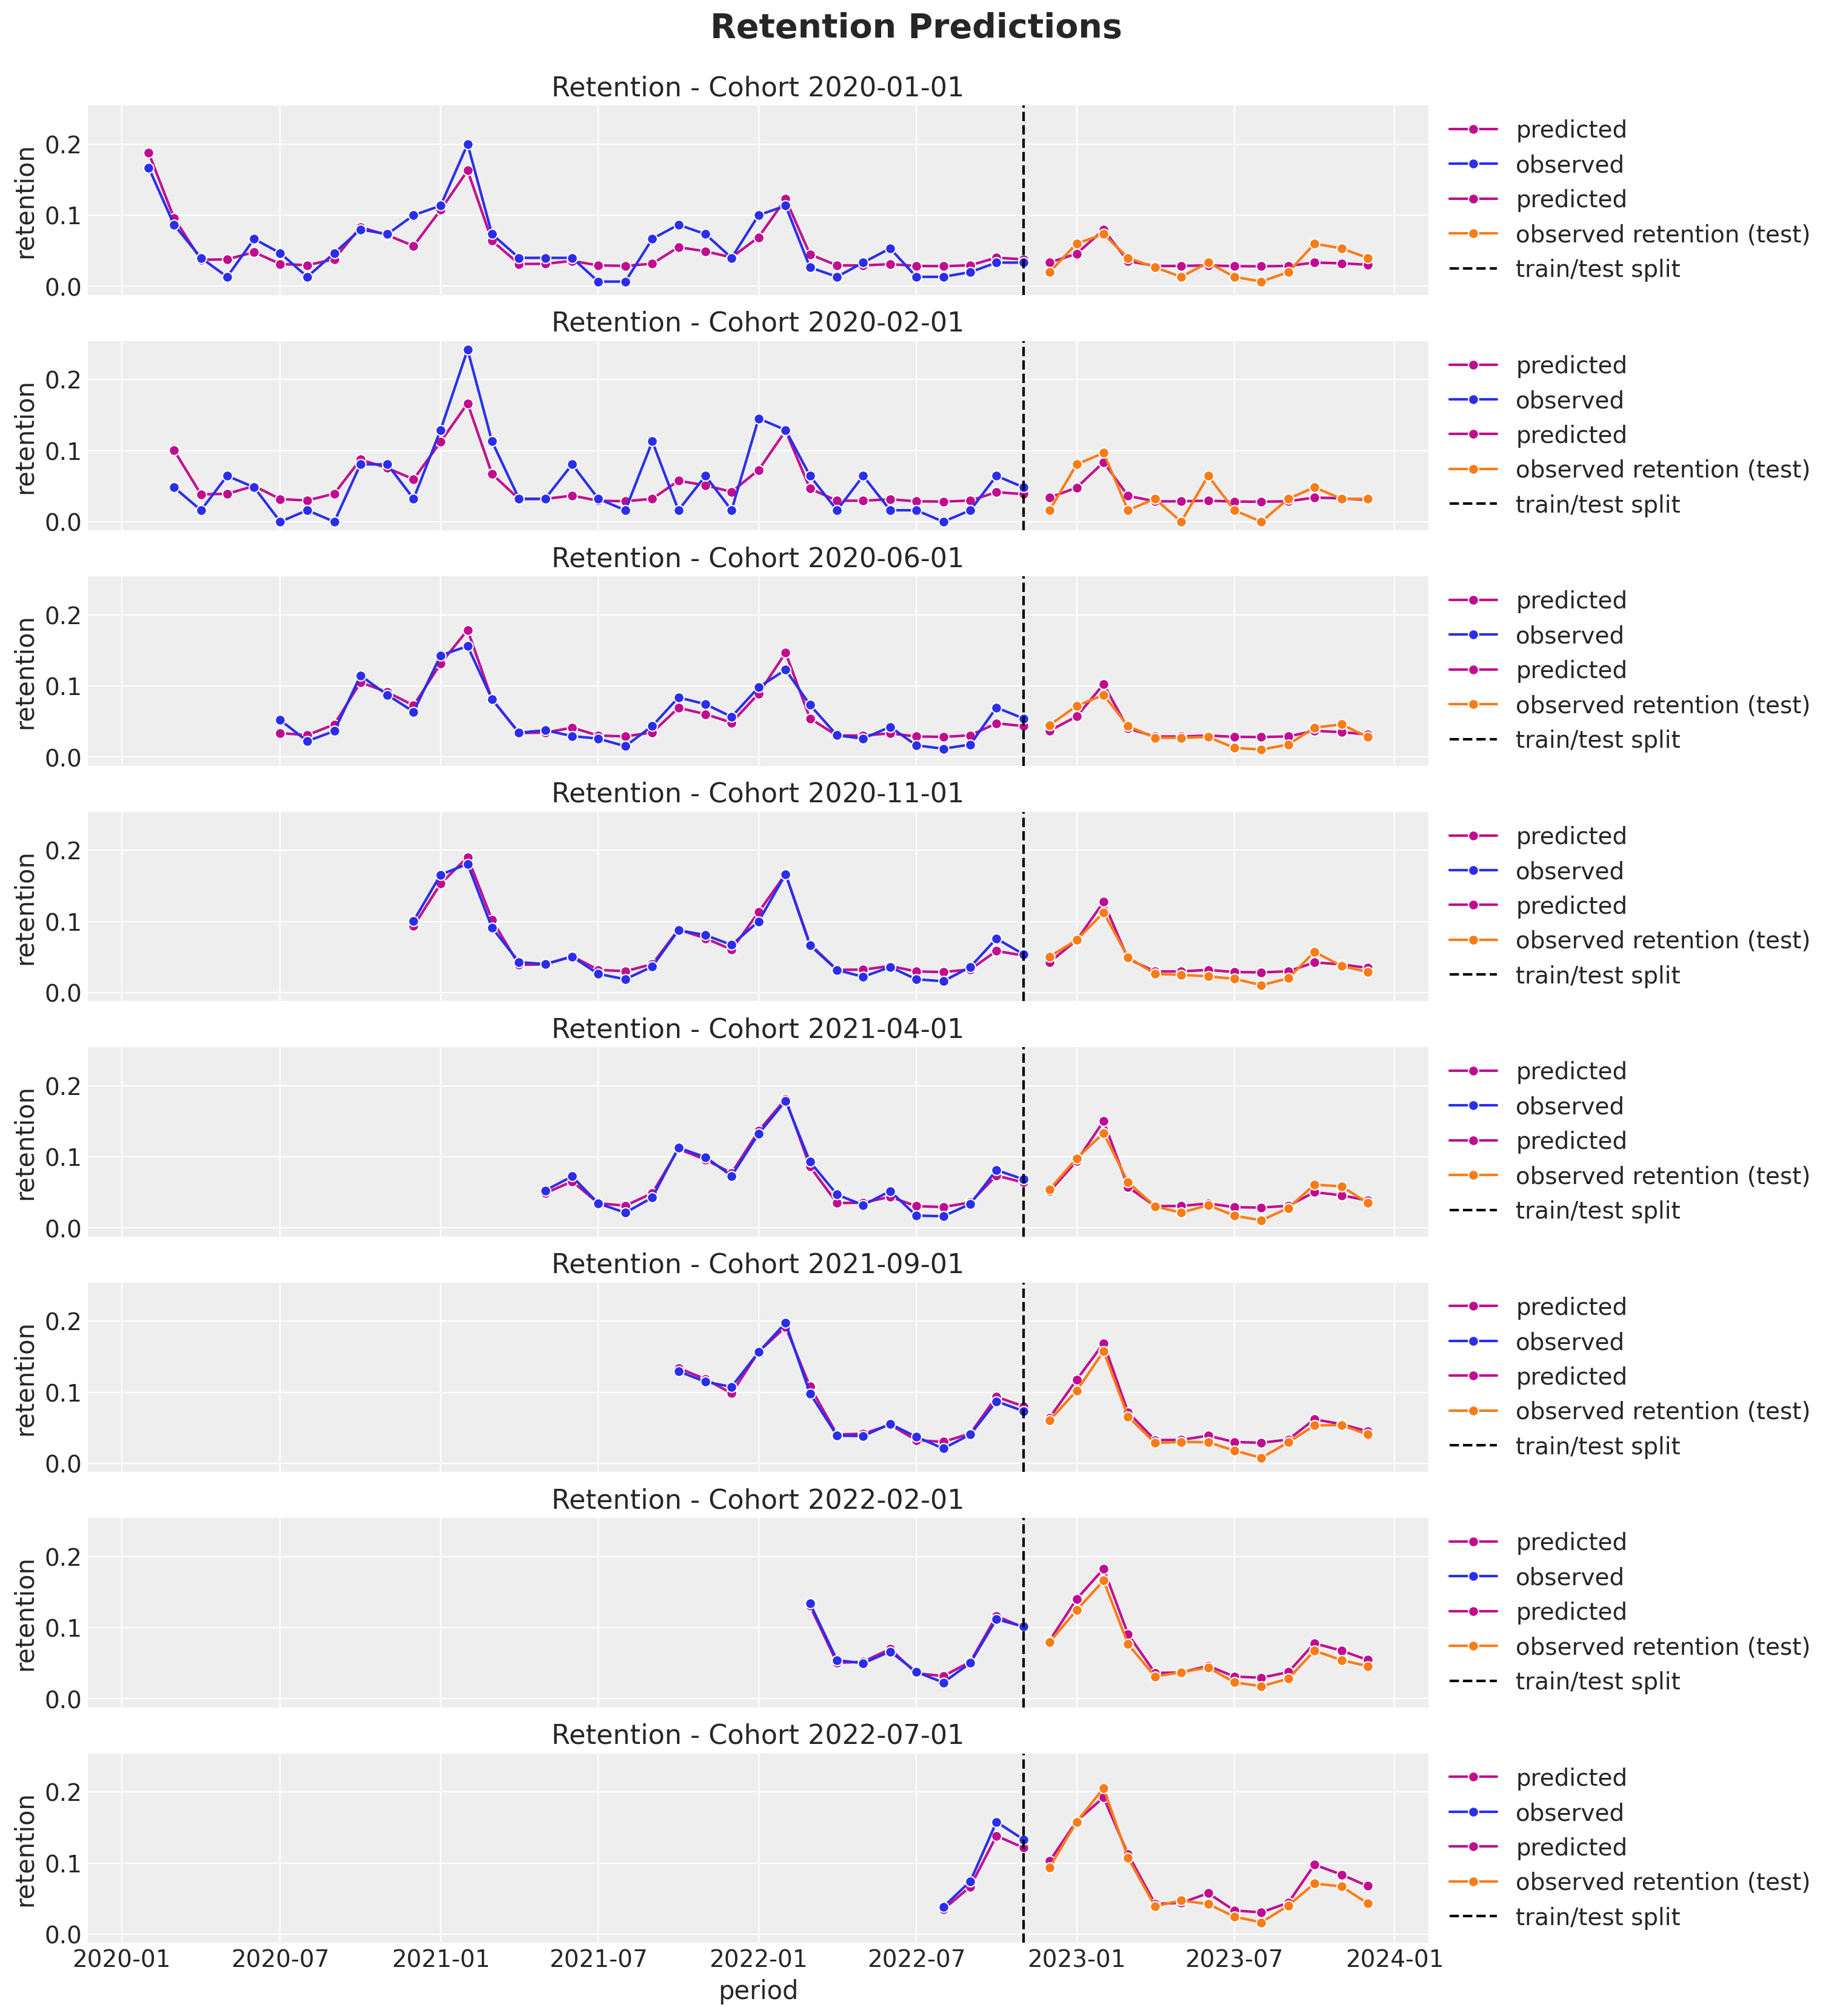

In [27]:
cohort_index_to_plot = [0, 1, 5, 10, 15, 20, 25, 30]

fig, axes = plt.subplots(
    nrows=len(cohort_index_to_plot),
    ncols=1,
    figsize=(15, 16),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for cohort_index, ax in zip(cohort_index_to_plot, axes.flatten(), strict=True):
    plot_train_retention_cohort(cohort_index=cohort_index, ax=ax)
    plot_test_retention_cohort(cohort_index=cohort_index, ax=ax)
    ax.axvline(
        x=pd.to_datetime(period_train_test_split),
        color="black",
        linestyle="--",
        label="train/test split",
    )
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
fig.suptitle("Retention Predictions", y=1.03, fontsize=20, fontweight="bold")